# Importing Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/YELP_RESULTS

/content/drive/MyDrive/YELP_RESULTS


In [3]:
max_len = 200
latent_dim = 30
manifold_dim = 10
epochs = 100

In [4]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense,Input
from keras.layers import LSTM, SimpleRNN, Embedding, Dropout
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

# Loading Data

In [5]:
data = pd.read_csv('yelp.csv')
data = data.rename(columns={"text": "review", "stars": "sentiment"})

In [6]:
data.head()

,business_id,date,review_id,sentiment,review,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [7]:
data.shape

(10000, 10)

# Data Pre-Processing

In [8]:
data.isnull().any()

business_id    False
date           False
review_id      False
sentiment      False
review         False
type           False
user_id        False
cool           False
useful         False
funny          False
dtype: bool

In [9]:
Tag = re.compile(r'<[^>]+>')

def remove(text):
  return Tag.sub('', text)

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
def preprocess(sen):
     sentence = sen.lower()

     # Remove html tags
     sentence = remove(sentence)

     # Remove punctuations and numbers
     sentence = re.sub('[^a-zA-Z]', ' ', sentence)

     # Single character removal
     sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

     # Remove multiple spaces
     sentence = re.sub(r'\s+', ' ', sentence)

     # Remove Stopwords
     pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
     sentence = pattern.sub('', sentence)

     return sentence

In [12]:
X = []
sentences = list(data['review'])
for sen in sentences:
    X.append(preprocess(sen))

In [13]:
Y = data['sentiment'].values

In [14]:
Y = np.array(list(map(lambda x: 0 if (x==1 or x==2) else 1, Y)))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [16]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [17]:
vocab_length = len(word_tokenizer.word_index)+1
vocab_length

25873

In [18]:
x_train=pad_sequences(X_train, padding='post',maxlen=max_len)
x_test=pad_sequences(X_test, padding='post',maxlen=max_len)

# **solve class imbalanced**

In [19]:
from collections import Counter
Counter(y_train)

Counter({1: 6632, 0: 1368})

In [20]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

oversample = RandomOverSampler(sampling_strategy=1)

x_train, y_train = oversample.fit_resample(x_train, y_train)
x_test, y_test = oversample.fit_resample(x_test, y_test)
Counter(y_train)

Counter({1: 6632, 0: 6632})

In [21]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_length, 300))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(25873, 300)

In [22]:
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=6d4b651f306ea6ec2cafcc55ce146881c1f45bc1144315a038e136ade65a7954
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [23]:
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D,LayerNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import keras
from keras_self_attention  import SeqSelfAttention # Self attention

input = Input(shape=(max_len,))
x = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=max_len , trainable=True)(input)
x = Bidirectional(LSTM(128, return_sequences = True))(x)
x = SeqSelfAttention(units = 128, attention_width= 10,
                           attention_type = SeqSelfAttention.ATTENTION_TYPE_MUL,
                           return_attention = False,
                           kernel_initializer = 'glorot_normal', bias_initializer= 'zeros',
                           kernel_regularizer = None, bias_regularizer = None,
                           kernel_constraint= None, bias_constraint= None,
                           use_additive_bias= True,
                           use_attention_bias = True, attention_activation = 'relu',
                           attention_regularizer_weight = 0)(x)
x = GlobalMaxPool1D()(x)
x = Dense(latent_dim, activation="relu")(x)
bottleneck = Dropout(0.2)(x)
output = Dense(1, activation="sigmoid")(bottleneck)

model = keras.Model(inputs=input, outputs=output)
encoder = Model(inputs = model.input, outputs = bottleneck)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=1)
history = model.fit(x_train,y_train, batch_size=64, epochs=100, validation_split=0.2,callbacks = [callback])

Epoch 1/100
166/166 [==============================] - 34s 170ms/step - loss: 0.3851 - accuracy: 0.8223 - val_loss: 0.3810 - val_accuracy: 0.8526
Epoch 2/100
166/166 [==============================] - 22s 132ms/step - loss: 0.1453 - accuracy: 0.9498 - val_loss: 0.1495 - val_accuracy: 0.9623
Epoch 3/100
166/166 [==============================] - 17s 103ms/step - loss: 0.0544 - accuracy: 0.9835 - val_loss: 0.0321 - val_accuracy: 0.9947
Epoch 4/100
166/166 [==============================] - 13s 79ms/step - loss: 0.0205 - accuracy: 0.9948 - val_loss: 0.0326 - val_accuracy: 0.9910


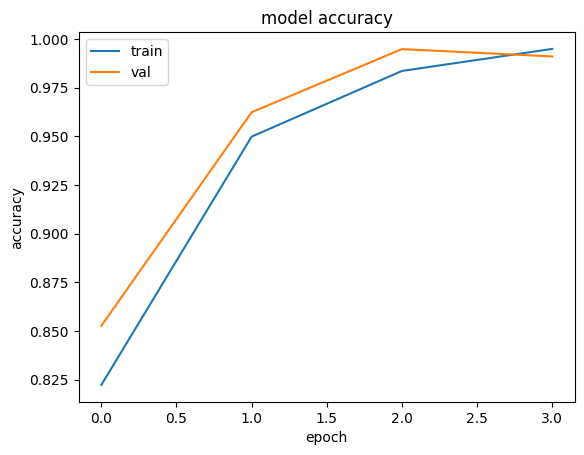

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

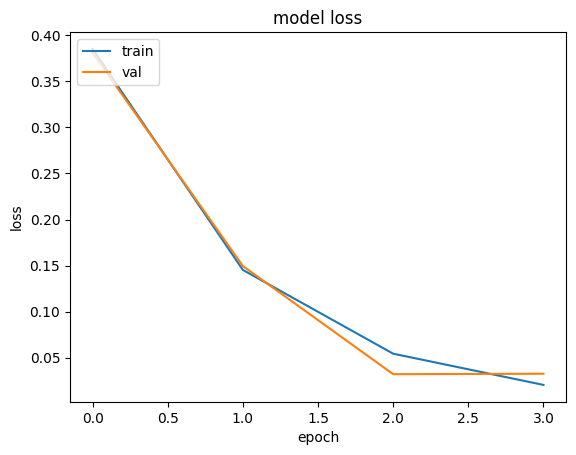

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

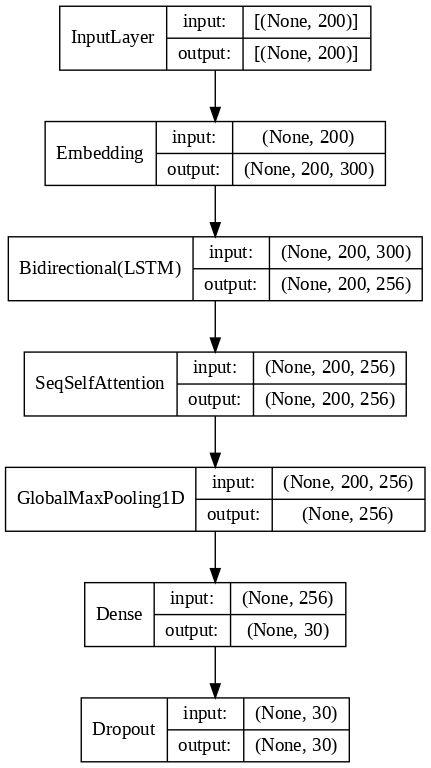

In [26]:
keras.utils.plot_model(
    encoder,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
    show_layer_activations=False,
    show_trainable=False,
)

In [27]:
x_encoded_train = encoder.predict(x_train)
x_encoded_test = encoder.predict(x_test)
print(x_encoded_train.shape, x_encoded_test.shape)

106/106 [==============================] - 1s 8ms/step
(13264, 30) (3384, 30)


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
 f1_score, confusion_matrix, classification_report)

--------------------------Results for manifold dimention-------------------
Accuracy: 0.17907801418439717
Precision: 0.21451104100946372
Recall: 0.24113475177304963
F1 score: 0.22704507512520866
              precision    recall  f1-score   support

           0       0.13      0.12      0.12      1692
           1       0.21      0.24      0.23      1692

    accuracy                           0.18      3384
   macro avg       0.17      0.18      0.18      3384
weighted avg       0.17      0.18      0.18      3384

--------------------------Results for 3d dimention-------------------
Accuracy: 0.23552009456264775
Precision: 0.2010688042752171
Recall: 0.17789598108747046
F1 score: 0.18877391031671373
              precision    recall  f1-score   support

           0       0.26      0.29      0.28      1692
           1       0.20      0.18      0.19      1692

    accuracy                           0.24      3384
   macro avg       0.23      0.24      0.23      3384
weighted avg      

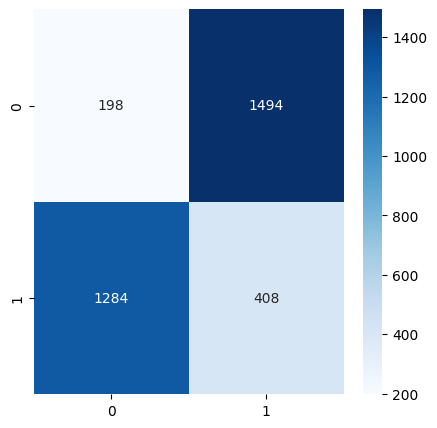

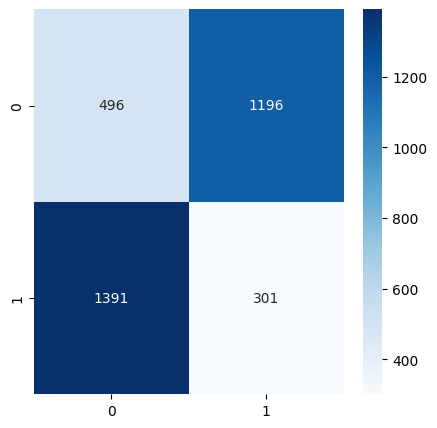

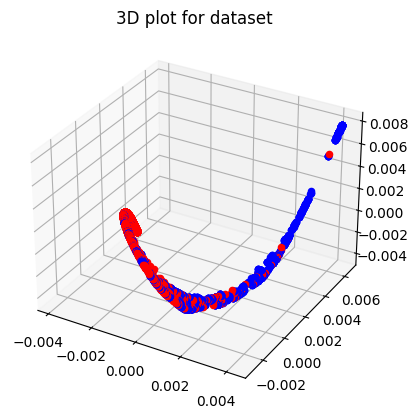

In [29]:
from sklearn.manifold import SpectralEmbedding

x_new_train = SpectralEmbedding(n_components=manifold_dim, n_neighbors=50, random_state=42).fit_transform(x_encoded_train)
x_new_test = SpectralEmbedding(n_components=manifold_dim, n_neighbors=50, random_state=42).fit_transform(x_encoded_test)

print('--------------------------Results for manifold dimention-------------------')

model = RandomForestClassifier().fit(x_new_train, y_train)
y_pred = model.predict(x_new_test)
y_pred = np.where(y_pred>0.55,1,0)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm , index=['0','1'] , columns=['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor='black', annot=True, fmt='')

print('--------------------------Results for 3d dimention-------------------')

x_new_train = SpectralEmbedding(n_components=3, n_neighbors=50, random_state=42).fit_transform(x_encoded_train)
x_new_test = SpectralEmbedding(n_components=3, n_neighbors=50, random_state=42).fit_transform(x_encoded_test)

model = RandomForestClassifier().fit(x_new_train, y_train)
y_pred = model.predict(x_new_test)
y_pred = np.where(y_pred>0.55,1,0)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm , index=['0','1'] , columns=['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor='black', annot=True, fmt='')

y_test = np.array(y_test)
fig = plt.figure()
ax = plt.axes(projection ='3d')
for i in range(len(y_test)):
    ax.scatter(x_new_test[i,0],x_new_test[i,1],x_new_test[i,2], c = 'r' if y_test[i]==1 else 'b')
    ax.plot3D(x_new_test[i,0],x_new_test[i,1],x_new_test[i,2], c = 'r' if y_test[i]==1 else 'b')
ax.set_title('3D plot for dataset')
plt.show()


--------------------------Results for manifold dimention-------------------
Accuracy: 0.6988770685579196
Precision: 0.7715899919289749
Recall: 0.5650118203309693
F1 score: 0.6523370863186626
              precision    recall  f1-score   support

           0       0.66      0.83      0.73      1692
           1       0.77      0.57      0.65      1692

    accuracy                           0.70      3384
   macro avg       0.71      0.70      0.69      3384
weighted avg       0.71      0.70      0.69      3384

--------------------------Results for 3d dimention-------------------
Accuracy: 0.1976950354609929
Precision: 0.07692307692307693
Recall: 0.0549645390070922
F1 score: 0.06411582213029991
              precision    recall  f1-score   support

           0       0.26      0.34      0.30      1692
           1       0.08      0.05      0.06      1692

    accuracy                           0.20      3384
   macro avg       0.17      0.20      0.18      3384
weighted avg       0.17

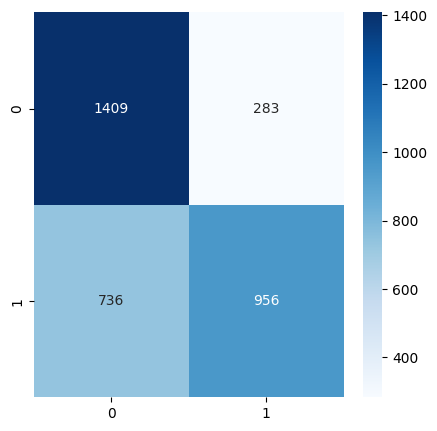

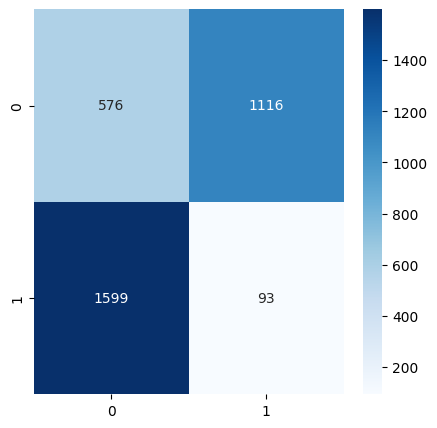

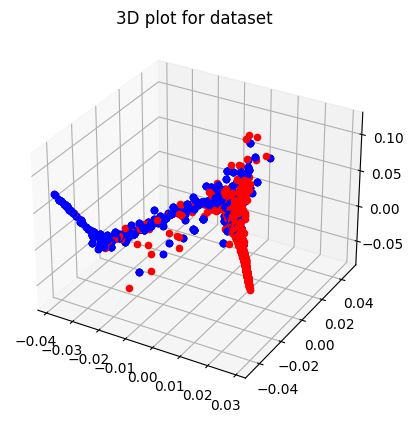

In [30]:
from sklearn.manifold import LocallyLinearEmbedding

x_new_train = LocallyLinearEmbedding(n_components=manifold_dim, n_neighbors=50, random_state=42).fit_transform(x_encoded_train)
x_new_test = LocallyLinearEmbedding(n_components=manifold_dim, n_neighbors=50, random_state=42).fit_transform(x_encoded_test)

print('--------------------------Results for manifold dimention-------------------')

model = RandomForestClassifier().fit(x_new_train, y_train)
y_pred = model.predict(x_new_test)
y_pred = np.where(y_pred>0.55,1,0)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm , index=['0','1'] , columns=['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor='black', annot=True, fmt='')

print('--------------------------Results for 3d dimention-------------------')

x_new_train = LocallyLinearEmbedding(n_components=3, n_neighbors=50, random_state=42).fit_transform(x_encoded_train)
x_new_test = LocallyLinearEmbedding(n_components=3, n_neighbors=50, random_state=42).fit_transform(x_encoded_test)

model = RandomForestClassifier().fit(x_new_train, y_train)
y_pred = model.predict(x_new_test)
y_pred = np.where(y_pred>0.55,1,0)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm , index=['0','1'] , columns=['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor='black', annot=True, fmt='')

y_test = np.array(y_test)

fig = plt.figure()
ax = plt.axes(projection ='3d')
for i in range(len(y_test)):
    ax.scatter(x_new_test[i,0],x_new_test[i,1],x_new_test[i,2], c = 'r' if y_test[i]==1 else 'b')
    ax.plot3D(x_new_test[i,0],x_new_test[i,1],x_new_test[i,2], c = 'r' if y_test[i]==1 else 'b')
ax.set_title('3D plot for dataset')
plt.show()


In [ ]:
# from sklearn.manifold import Isomap
# manifold_dim = 10
# x_new_train = Isomap(n_components = manifold_dim,
#                            metric = "euclidean",
#                            n_neighbors = 50).fit_transform(x_encoded_train)

# x_new_test = Isomap(n_components = manifold_dim,
#                            metric = "euclidean",
#                            n_neighbors = 50).fit_transform(x_encoded_test)

# print('--------------------------Results for manifold dimention-------------------')

# model = RandomForestClassifier().fit(x_new_train, y_train)
# y_pred = model.predict(x_new_test)
# y_pred = np.where(y_pred>0.55,1,0)

# print('Accuracy:', accuracy_score(y_test, y_pred))
# print('Precision:', precision_score(y_test, y_pred))
# print('Recall:', recall_score(y_test, y_pred))
# print('F1 score:', f1_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# import seaborn as sns
# cm = confusion_matrix(y_test,y_pred)
# cm = pd.DataFrame(cm , index=['0','1'] , columns=['0','1'])
# plt.figure(figsize = (5,5))
# sns.heatmap(cm,cmap= "Blues", linecolor='black', annot=True, fmt='')

# x_new_train = Isomap(n_components = 3,
#                            metric = "euclidean",
#                            n_neighbors = 50).fit_transform(x_encoded_train)

# x_new_test = Isomap(n_components = 3,
#                            metric = "euclidean",
#                            n_neighbors = 50).fit_transform(x_encoded_test)

# print('--------------------------Results for 3d dimention -------------------')
# model = RandomForestClassifier().fit(x_new_train, y_train)
# y_pred = model.predict(x_new_test)
# y_pred = np.where(y_pred>0.55,1,0)

# print('Accuracy:', accuracy_score(y_test, y_pred))
# print('Precision:', precision_score(y_test, y_pred))
# print('Recall:', recall_score(y_test, y_pred))
# print('F1 score:', f1_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# import seaborn as sns
# cm = confusion_matrix(y_test,y_pred)
# cm = pd.DataFrame(cm , index=['0','1'] , columns=['0','1'])
# plt.figure(figsize = (5,5))
# sns.heatmap(cm,cmap= "Blues", linecolor='black', annot=True, fmt='')
# y_test = np.array(y_test)
# fig = plt.figure()
# ax = plt.axes(projection ='3d')
# for i in range(len(y_test)):
#     ax.scatter(x_new_test[i,0],x_new_test[i,1],x_new_test[i,2], c = 'r' if y_test[i]==1 else 'b')
#     ax.plot3D(x_new_test[i,0],x_new_test[i,1],x_new_test[i,2], c = 'r' if y_test[i]==1 else 'b')
# ax.set_title('3D plot for dataset')
# plt.show()

In [ ]:
# from sklearn.manifold import TSNE

# x_new_train = TSNE(n_components= manifold_dim,
#                    metric = "euclidean",  method = 'exact',
#                    random_state = 13).fit_transform(x_encoded_train)
# x_new_test = TSNE(n_components= manifold_dim,
#                   metric = "euclidean",  method = 'exact',
#                   random_state = 13).fit_transform(x_encoded_test)

# print('--------------------------Results for manifold dimention-------------------')
# model = RandomForestClassifier().fit(x_new_train, y_train)
# y_pred = model.predict(x_new_test)
# y_pred = np.where(y_pred>0.55,1,0)

# print('Accuracy:', accuracy_score(y_test, y_pred))
# print('Precision:', precision_score(y_test, y_pred))
# print('Recall:', recall_score(y_test, y_pred))
# print('F1 score:', f1_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# import seaborn as sns
# cm = confusion_matrix(y_test,y_pred)
# cm = pd.DataFrame(cm , index=['0','1'] , columns=['0','1'])
# plt.figure(figsize = (5,5))
# sns.heatmap(cm,cmap= "Blues", linecolor='black', annot=True, fmt='')

# x_new_train = TSNE(n_components= 3,
#                    metric = "euclidean",  method = 'exact',
#                    random_state = 13).fit_transform(x_encoded_train)
# x_new_test = TSNE(n_components= 3,
#                   metric = "euclidean",  method = 'exact',
#                   random_state = 13).fit_transform(x_encoded_test)

# print('--------------------------Results for 3d dimention-------------------')

# model = RandomForestClassifier().fit(x_new_train, y_train)
# y_pred = model.predict(x_new_test)
# y_pred = np.where(y_pred>0.55,1,0)

# print('Accuracy:', accuracy_score(y_test, y_pred))
# print('Precision:', precision_score(y_test, y_pred))
# print('Recall:', recall_score(y_test, y_pred))
# print('F1 score:', f1_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# import seaborn as sns
# cm = confusion_matrix(y_test,y_pred)
# cm = pd.DataFrame(cm , index=['0','1'] , columns=['0','1'])
# plt.figure(figsize = (5,5))
# sns.heatmap(cm,cmap= "Blues", linecolor='black', annot=True, fmt='')
# y_test = np.array(y_test)
# fig = plt.figure()
# ax = plt.axes(projection ='3d')
# for i in range(len(y_test)):
#     ax.scatter(x_new_test[i,0],x_new_test[i,1],x_new_test[i,2], c = 'r' if y_test[i]==1 else 'b')
#     ax.plot3D(x_new_test[i,0],x_new_test[i,1],x_new_test[i,2], c = 'r' if y_test[i]==1 else 'b')
# ax.set_title('3D plot for dataset')
# plt.show()

In [ ]:
from sklearn.manifold import MDS # Multidimensional scaling (MDS)


x_new_train = MDS(n_components=manifold_dim, max_iter=50,n_init=4,random_state=0).fit_transform(x_encoded_train.astype(np.float64))
x_new_test = MDS(n_components=manifold_dim, max_iter=50,n_init=4,random_state=0).fit_transform(x_encoded_test.astype(np.float64))
print('--------------------------Results for manifold dimention-------------------')
model = RandomForestClassifier().fit(x_new_train, y_train)
y_pred = model.predict(x_new_test)
y_pred = np.where(y_pred>0.55,1,0)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
import seaborn as sns
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm , index=['0','1'] , columns=['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor='black', annot=True, fmt='')

print('--------------------------Results for 3d dimention-------------------')

x_new_train = MDS(n_components=3, max_iter=50,n_init=4,random_state=0, normalized_stress=False).fit_transform(x_encoded_train.astype(np.float64))
x_new_test = MDS(n_components=3, max_iter=50,n_init=4,random_state=0, normalized_stress=False).fit_transform(x_encoded_test.astype(np.float64))

model = RandomForestClassifier().fit(x_new_train, y_train)
y_pred = model.predict(x_new_test)
y_pred = np.where(y_pred>0.55,1,0)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
import seaborn as sns
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm , index=['0','1'] , columns=['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor='black', annot=True, fmt='')

y_test = np.array(y_test)
fig = plt.figure()
ax = plt.axes(projection ='3d')
for i in range(len(y_test)):
    ax.scatter(x_new_test[i,0],x_new_test[i,1],x_new_test[i,2], c = 'r' if y_test[i]==1 else 'b')
    ax.plot3D(x_new_test[i,0],x_new_test[i,1],x_new_test[i,2], c = 'r' if y_test[i]==1 else 'b')
ax.set_title('3D plot for dataset')
plt.show()
